In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [106]:
#could add sources so only those used to fit are considered
def getMasses(redshifts):
    data = ares.analysis.GalaxyPopulation()

    Ms = []
    for z in redshifts:
        data_info = data.compile_data(z, quantity='smf')

        # print(data_info)

        mass = []
        for i in data_info:
    #         mass.append(data_info[i]["M"][~data_info[i]["M"].mask])
            mass.extend(data_info[i]["M"].compressed())

        Ms.extend(mass)

    Ms = list(set(Ms))
    Ms = np.sort(Ms)
    return Ms

In [152]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

# redshifts = np.array([4, 5, 6, 7, 8])

# [0.10165, 0.25, 0.35, 0.45, 0.575, 0.725, 0.9][1.65, 2.5, 3.5]
# Ms = np.logspace(7, 12, 60)
Ms = getMasses(redshifts)

# print(Ms)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('bins', Ms)]
blob_f1 = ['StellarMassFunction']

No z=0.10165 data in song2016.
No z=0.10165 data in stefanon2017.
No z=0.10165 data in duncan2014.
No z=0.10165 data in tomczak2014.
No z=0.10165 data in mortlock2011.
No z=0.10165 data in marchesini2009_10.
No z=0.10165 data in perez2008.
No z=0.25 data in song2016.
No z=0.25 data in stefanon2017.
No z=0.25 data in duncan2014.
No z=0.25 data in tomczak2014.
No z=0.25 data in mortlock2011.
No z=0.25 data in marchesini2009_10.
No z=0.25 data in perez2008.
No z=0.35 data in song2016.
No z=0.35 data in stefanon2017.
No z=0.35 data in duncan2014.
No z=0.35 data in mortlock2011.
No z=0.35 data in marchesini2009_10.
No z=0.35 data in perez2008.
No z=0.45 data in song2016.
No z=0.45 data in stefanon2017.
No z=0.45 data in duncan2014.
No z=0.45 data in tomczak2014.
No z=0.45 data in mortlock2011.
No z=0.45 data in marchesini2009_10.
No z=0.45 data in perez2008.
No z=0.575 data in song2016.
No z=0.575 data in stefanon2017.
No z=0.575 data in duncan2014.
No z=0.575 data in tomczak2014.
No z=0.57

In [153]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [154]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)
base_pars.update({'progress_bar': True, 'debug':True})


# This is important!
# base_pars['pop_calib_lum'] = None

In [155]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0.001, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, .9),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(0, 2),  'pq_func_par2[3]')

In [156]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [157]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [158]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [159]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [160]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 50

# fitter.jitter = [0.1] * len(fitter.parameters)
fitter.jitter = [0.1, 0.1, 0.01, 0.05, 0.1, 0.1, 0.8, 0.1]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops

# Fixing position of walker 18 (parameter pq_func_par0[2])
# Moved from 0.9167267301146598 to 0.45244362145103345
# Fixing position of walker 2 (parameter pq_func_par2[3])
# Moved from -0.0022261863095220137 to 0.006041047612621571
# Fixing position of walker 4 (parameter pq_func_par2[3])
# Moved from -0.034971671863125844 to 0.052800846400526236
# Fixing position of walker 5 (parameter pq_func_par2[3])
# Moved from -0.08268652944644724 to 0.04373963604861085
# Fixing position of walker 6 (parameter pq_func_par2[3])
# Moved from -0.07093471122543624 to 0.011373544141491627
# Fixing position of walker 7 (parameter pq_func_par2[3])
# Moved from -0.020615822722809613 to 0.1456277737083286
# Fixing position of walker 9 (parameter pq_func_par2[3])
# Moved from -0.08657025605259458 to 0.05582346278099834
# Fixing position of walker 12 (parameter pq_func_par2[3])
# Moved from -0.012783873695922345 to 0.08756417059157111
# Fixing position of walker 14 (parameter pq_func_par2[3])
# Moved from -

In [161]:
# Run the thing
fitter.run('test_smfcal', burn=10, steps=50, save_freq=2, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Thu Jun 25 13:48:29 2020
# Wrote test_smfcal.burn.dd0000.facc.pkl: Thu Jun 25 13:54:59 2020
# Wrote test_smfcal.burn.dd0001.facc.pkl: Thu Jun 25 13:59:24 2020
# Wrote test_smfcal.burn.dd0002.facc.pkl: Thu Jun 25 14:04:58 2020
# Wrote test_smfcal.burn.dd0003.facc.pkl: Thu Jun 25 14:09:32 2020
# Wrote test_smfcal.burn.dd0004.facc.pkl: Thu Jun 25 14:14:13 2020
# Burn-in complete in 1.54e+03 seconds.
# Fixing position of walker 1 (parameter pq_func_par0[3])
# Moved from 14.16781433217573 to 13.292818382717497
# Fixing position of walker 18 (parameter pq_func_par0[3])
# Moved from 14.088949868048756 to 13.3045849913638
# Fixing position of walker 48 (parameter pq_func_par0[3])
# Moved from 14.349432791199549 to 13.833555985446685
# Starting MCMC: Thu Jun 25 14:14:14 2020
# Wrote test_smfcal.dd0000.facc.pkl: Thu Jun 25 14:22:21 2020
# Wrote test_smfcal.dd0001.facc.pkl: Thu Jun 25 14:29:15 2020
# Wrote test_smfcal.dd0002.facc.p

In [183]:
anl = ares.analysis.ModelSet('test_smfcal')
# anl = ares.analysis.ModelSet('smf_run2')

labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_smfcal                                                                            ####
#### N-d         : 8                                                                                      ####


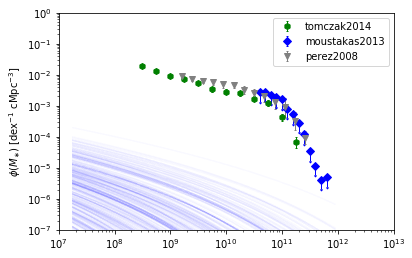

In [186]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.875
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [187]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 2.118234e+00
pq_func_par2[0]: 1.347431e-01
pq_func_par0[1]: 5.173042e-02
pq_func_par2[1]: -6.093293e-01
pq_func_par0[2]: 3.363197e-01
pq_func_par2[2]: -2.233624e-01
pq_func_par0[3]: 1.344272e+01
pq_func_par2[3]: 5.563498e-01


0 of 2500 chain elements ignored because of chain links with inf's/nan's.


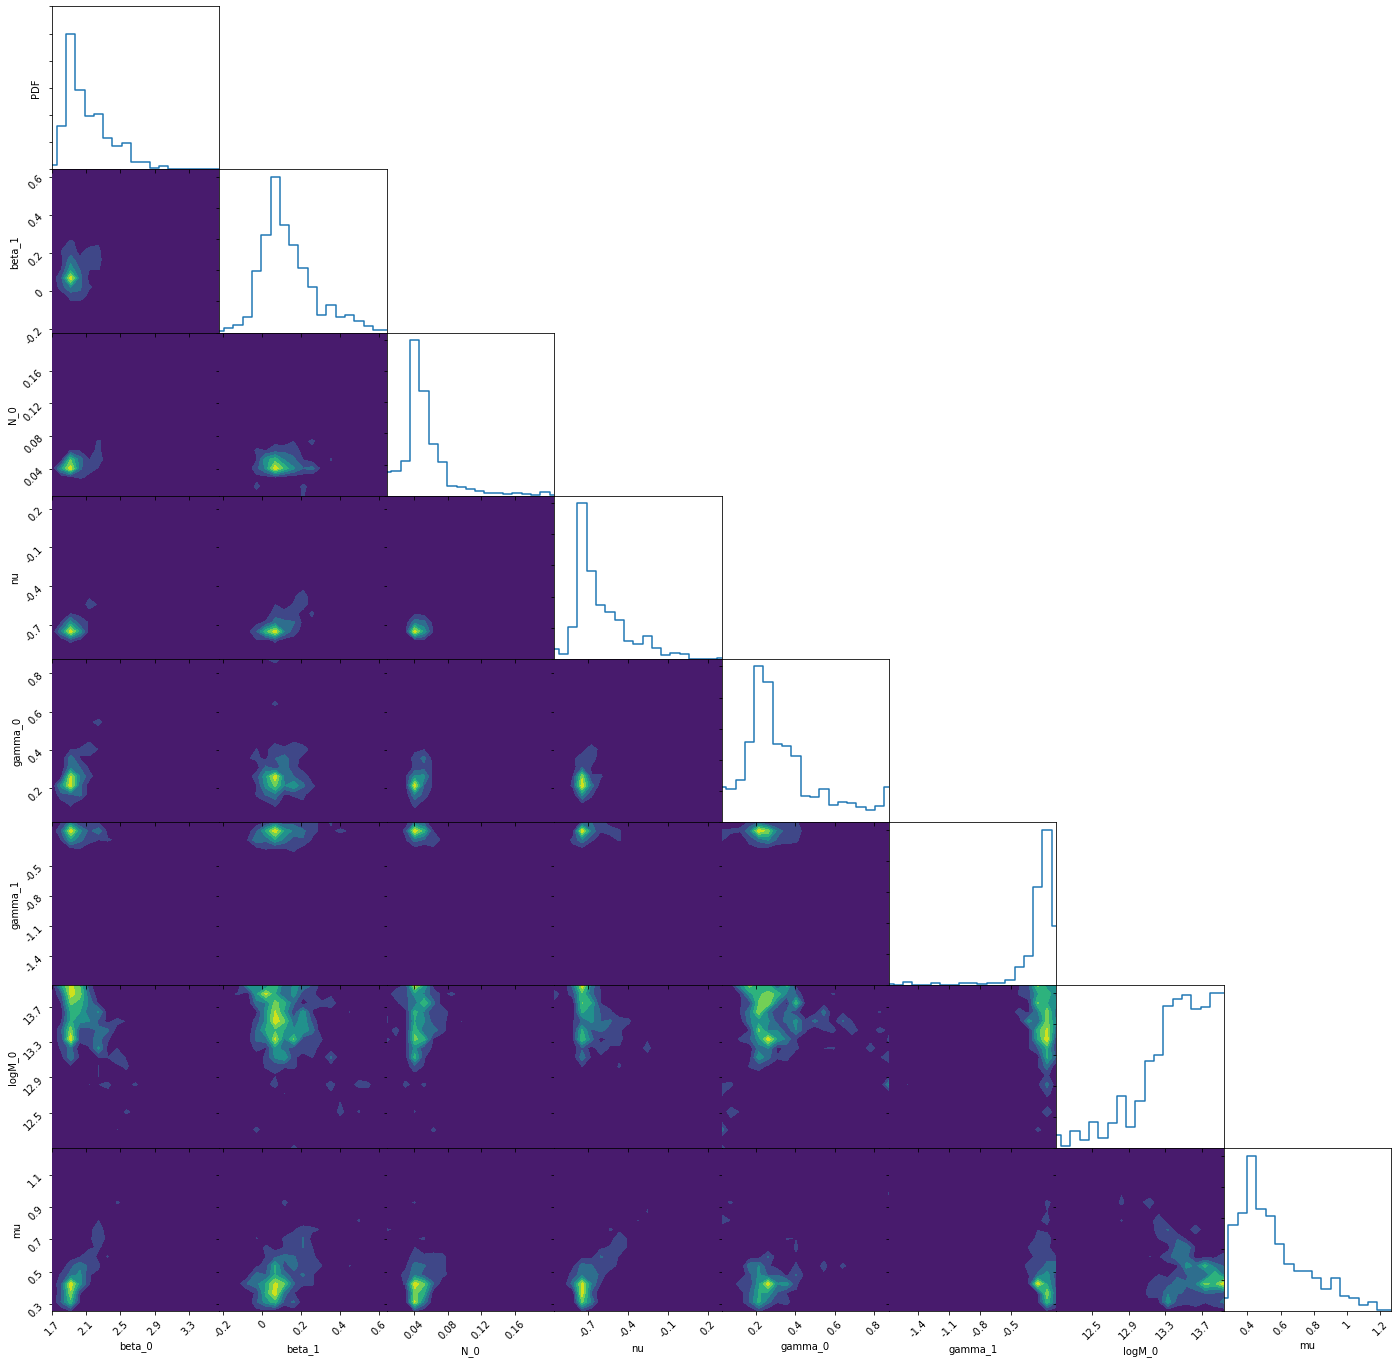

In [188]:

anl.TrianglePlot(pars=params)

In [ ]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [189]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 2.124586222886101,
 'pq_func_par2[0]': 0.012521576630950548,
 'pq_func_par0[1]': 0.2081249718011321,
 'pq_func_par2[1]': -0.4208300165249582,
 'pq_func_par0[2]': 0.5015029974622123,
 'pq_func_par2[2]': -1.7302989101389745,
 'pq_func_par0[3]': 12.878407966407043,
 'pq_func_par2[3]': 1.2590102177802898}

In [190]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 2.118234e+00
pq_func_par2[0]: 1.347431e-01
pq_func_par0[1]: 5.173042e-02
pq_func_par2[1]: -6.093293e-01
pq_func_par0[2]: 3.363197e-01
pq_func_par2[2]: -2.233624e-01
pq_func_par0[3]: 1.344272e+01
pq_func_par2[3]: 5.563498e-01


In [191]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [192]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(2.124586222886101, array([0.26982535, 0.23325001]))
(0.012521576630950548, array([ 0.24677428, -0.00321566]))
(0.2081249718011321, array([-0.1385009 ,  0.17527044]))
(-0.4208300165249582, array([-0.00959409,  0.33364357]))
(0.5015029974622123, array([0.04751084, 0.32948909]))
(-1.7302989101389745, array([ 1.62452423, -1.43731773]))
(12.878407966407043, array([ 0.95863717, -0.20887219]))
(1.2590102177802898, array([-0.48772155,  0.88461989]))


In [193]:
pars_best = ares.util.ParameterBundle("emma:model1")
print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 2.124586222886101, 'pq_func_par2[0]': 0.012521576630950548, 'pq_func_par0[1]': 0.2081249718011321, 'pq_func_par2[1]': -0.4208300165249582, 'pq_func_par0[2]': 0.5015029974622123, 'pq_func_par2[2]': -1.7302989101389745, 'pq_func_par0[3]': 12.878407966407043, 'pq_func_par2[3]': 1.2590102177802898}


In [198]:
z = 0.35

Ms_short = np.logspace(8, 12, 50)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)
# ls_best_2 = pop_best_2.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
obslf.Plot(z=z, round_z=0.2)

pl.loglog(Ms_short, ls_best, label='Best fit')
# pl.loglog(Ms_short, ls_best_2, label='Best fit 2')

pl.loglog(Ms_short, ls_mean, label='Mean fit')
pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-9, 1e2)
pl.show()

[2.03562079e-09 1.49506166e-09 1.08605349e-09 7.79908782e-10
 5.53358312e-10 3.87696725e-10 2.68062494e-10 1.82798870e-10
 1.22859862e-10 8.13291404e-11 5.29869160e-11 3.39493639e-11
 2.13744997e-11 1.32124464e-11 8.01125207e-12 4.76046956e-12
 2.76934679e-12 1.57559597e-12 8.75722922e-13 4.74919695e-13
 2.51016367e-13 1.29125623e-13 6.45623781e-14 3.13316599e-14
 1.47338766e-14 6.70421300e-15 2.94631119e-15 1.24839276e-15
 5.09079145e-16 1.99343820e-16 7.48200274e-17 2.68514212e-17
 9.19216816e-18 2.99514532e-18 9.25915820e-19 2.70969485e-19
 7.48250530e-20 1.94300771e-20 4.73286315e-21 1.07624788e-21
 2.27878671e-22 4.47332935e-23 8.09865593e-24 1.34917211e-24
 2.05260839e-25 2.84369248e-26 3.56867313e-27 4.02144990e-28
 4.06959817e-29 3.65375467e-30]


ValueError: math domain error